# The Workflow for Getting Weights of Channels

Import the related libraries

In [198]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from scipy import signal
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import os
from tensorflow.keras.models import Sequential, Model, load_model
import datetime
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras as K
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

Get the data from Subject 18. All the 17 gesture will be imported for the .mat file, however, the first 6 will be used for classification attempt.

In [199]:
def get_data(path,file):
    mat = loadmat(os.path.join(path,file))
    data = pd.DataFrame(mat['emg'])
    data['stimulus'] = mat['restimulus'] 
    data['repetition'] = mat['repetition']
    
    return data
df = get_data(r'C:\Ninapro', 'S18_E1_A1.mat')

Check the data and plot.

In [200]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
0,-0.000004,-9.538705e-07,4.721677e-08,-0.000005,-5.207978e-06,0.000003,0.000006,0.000010,0.000006,-1.080232e-05,3.829718e-06,-3.349643e-07,0,0
1,-0.000003,-1.457232e-06,1.390011e-06,-0.000006,-5.207924e-06,0.000004,0.000004,0.000014,0.000006,-1.183897e-05,5.341656e-07,-8.319711e-08,0,0
2,-0.000003,-7.856474e-07,1.054312e-06,-0.000007,-3.865075e-06,0.000005,0.000006,0.000015,0.000005,-7.476332e-06,8.356469e-06,-8.135908e-07,0,0
3,-0.000004,2.235825e-06,-1.295577e-06,-0.000006,-2.018680e-06,0.000004,0.000006,0.000013,0.000001,-9.985375e-07,1.533874e-05,-2.187418e-06,0,0
4,-0.000003,4.921599e-06,-2.806220e-06,-0.000006,-8.436827e-07,0.000002,0.000003,0.000013,-0.000003,-3.268624e-06,1.177741e-05,-3.139474e-06,0,0


Totally 12 channels, repetition as well as gesture information are included.

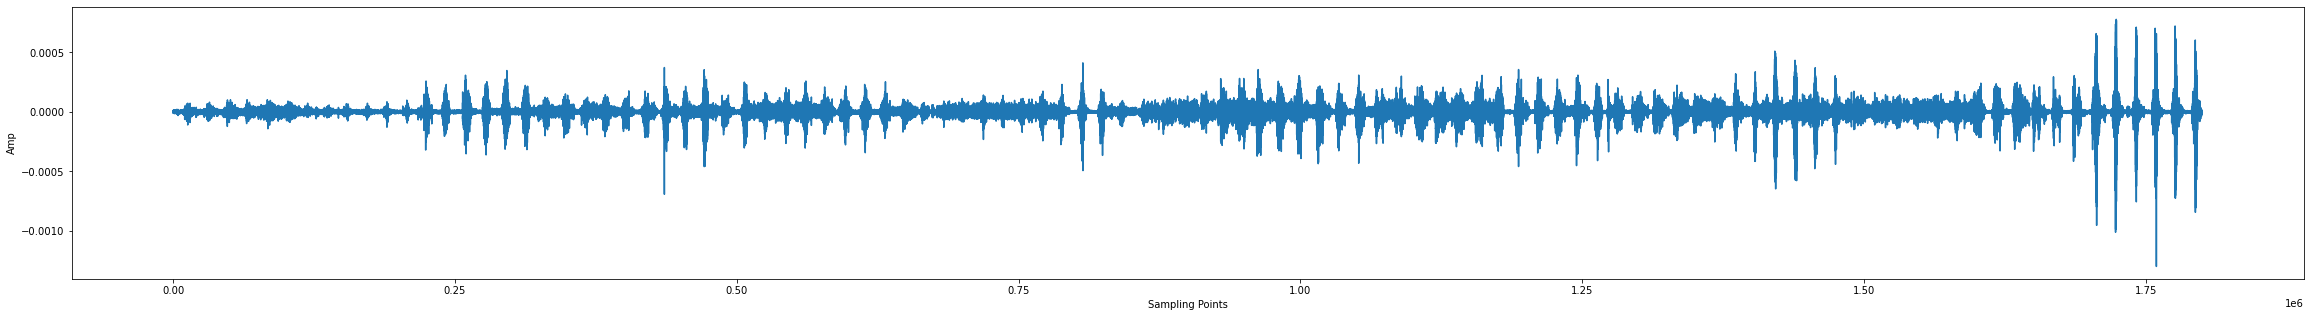

In [201]:
figure(figsize=(40, 5))

plt.plot(df[0])
plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()

Perform data normalization to ensure uniformity in how the data looks, reads, and can be utilized. Repetition 1,3,4,5 are used for traning for the scaler, then applied on the whole data.

In [203]:
def normalise(data, train_reps):
    x = [np.where(data.values[:,13] == rep) for rep in train_reps]
    indices = np.squeeze(np.concatenate(x, axis = -1))
    train_data = data.iloc[indices, :]
    train_data = data.reset_index(drop=True)
    
    scaler = StandardScaler(with_mean=True,
                                with_std=True,
                                copy=False).fit(train_data.iloc[:, :12])
    
    scaled = scaler.transform(data.iloc[:,:12])
    normalised = pd.DataFrame(scaled)
    normalised['stimulus'] = data['stimulus']
    normalised['repetition'] = data['repetition']
    return normalised

In [204]:
df2 = normalise (df, [1,3,4,6])

In [205]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
0,-0.130212,-0.034529,0.016399,-0.257145,-0.427733,0.418933,0.413435,0.216954,0.279524,-0.322568,0.248304,-0.030557,0,0
1,-0.091755,-0.052645,0.098756,-0.320963,-0.427728,0.607845,0.278243,0.317352,0.275230,-0.353518,0.039592,-0.008715,0,0
2,-0.091752,-0.028475,0.078167,-0.357428,-0.317283,0.749538,0.413443,0.335697,0.228094,-0.223270,0.534989,-0.072079,0,0
3,-0.146683,0.080265,-0.065958,-0.330067,-0.165423,0.607920,0.413447,0.284621,0.063527,-0.029873,0.977187,-0.191262,0,0
4,-0.091746,0.176923,-0.158610,-0.348296,-0.068782,0.324647,0.233189,0.296004,-0.159949,-0.097647,0.751642,-0.273855,0,0


Filter the data with low noise or high noise frequencies by Butterworth. The bandpass could clean the high and low frequency noisy information.

In [207]:
def filter_data(data, f, butterworth_order = 4, btype = 'lowpass'):
    emg_data = data.values[:,:12]
    
    f_sampling = 2000
    nyquist = f_sampling/2
    if isinstance(f, int):
        fc = f/nyquist
    else:
        fc = list(f)
        for i in range(len(f)):
            fc[i] = fc[i]/nyquist
            
    b,a = signal.butter(butterworth_order, fc, btype=btype)
    transpose = emg_data.T.copy()
    
    for i in range(len(transpose)):
        transpose[i] = (signal.lfilter(b, a, transpose[i]))
    
    filtered = pd.DataFrame(transpose.T)
    filtered['stimulus'] = data['stimulus']
    filtered['repetition'] = data['repetition']
    
    return filtered

In [235]:
#emg_low = filter_data(data=df2, f=20, butterworth_order=4, btype='lowpass') 
emg_band = filter_data(data=df2, f=(20,40), butterworth_order=4, btype='bandpass') 
#emg_high = filter_data(data=df2, f=20, butterworth_order=4, btype='high') 

In [236]:
emg_band.head()

,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
0,-1.169935e-07,-3.102418e-08,1.473424e-08,-2.310411e-07,-3.843121e-07,3.764056e-07,3.714659e-07,1.949303e-07,2.511487e-07,-2.898232e-07,2.230977e-07,-2.745465e-08,0,0
1,-9.955629e-07,-2.894414e-07,2.037301e-07,-2.091634e-06,-3.383826e-06,3.483948e-06,3.149252e-06,1.806548e-06,2.207481e-06,-2.579673e-06,1.776828e-06,-2.221112e-07,0,0
2,-4.263031e-06,-1.332740e-06,1.208238e-06,-9.557170e-06,-1.490376e-05,1.631618e-05,1.355349e-05,8.420560e-06,9.728187e-06,-1.144213e-05,7.503406e-06,-9.559344e-07,0,0
3,-1.261590e-05,-4.036592e-06,4.348874e-06,-2.998292e-05,-4.470061e-05,5.239045e-05,4.051061e-05,2.680622e-05,2.920082e-05,-3.435365e-05,2.353147e-05,-3.107772e-06,0,0
4,-2.965515e-05,-8.992730e-06,1.105959e-05,-7.381830e-05,-1.044869e-04,1.311774e-04,9.611692e-05,6.659527e-05,6.804126e-05,-7.996047e-05,6.202024e-05,-8.738634e-06,0,0


Observe the filtered channels

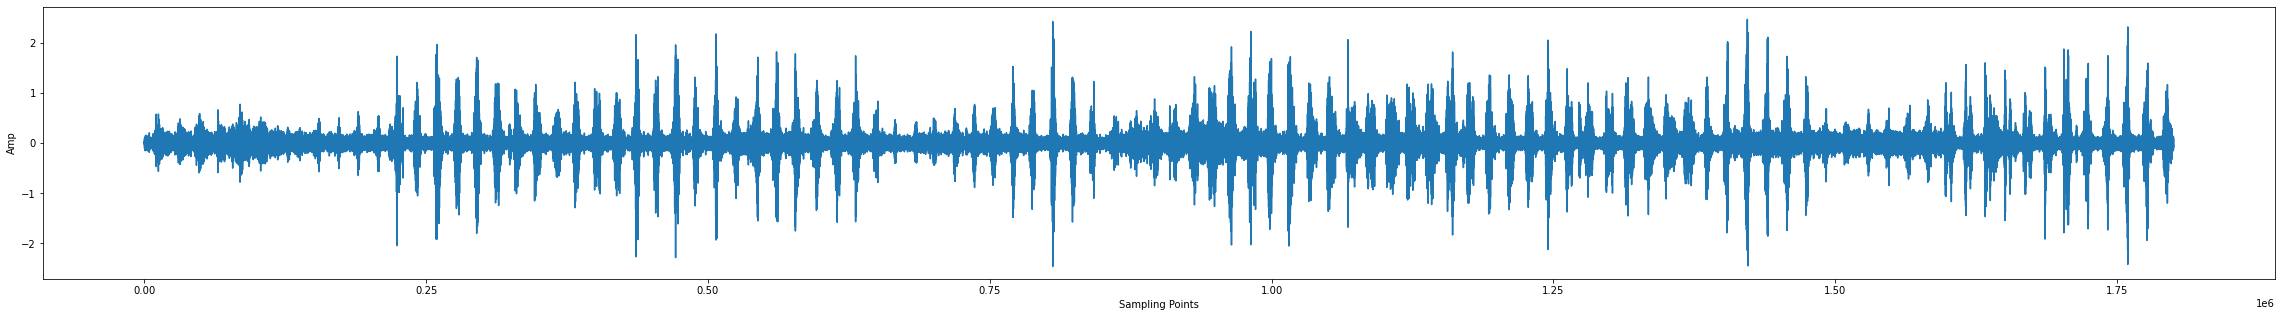

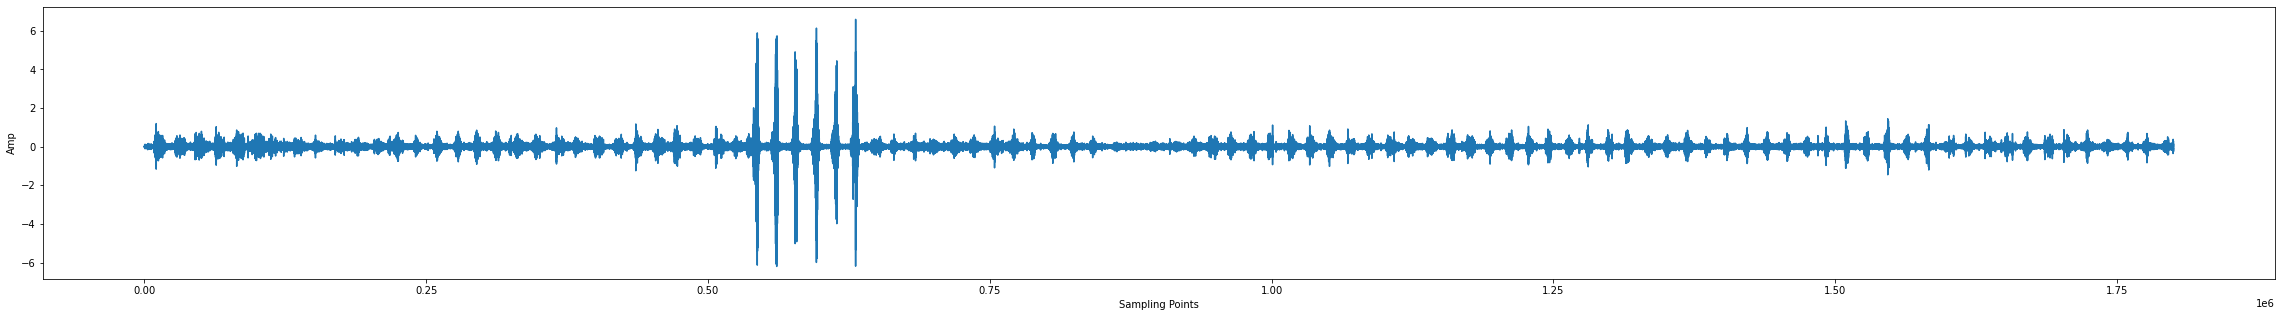

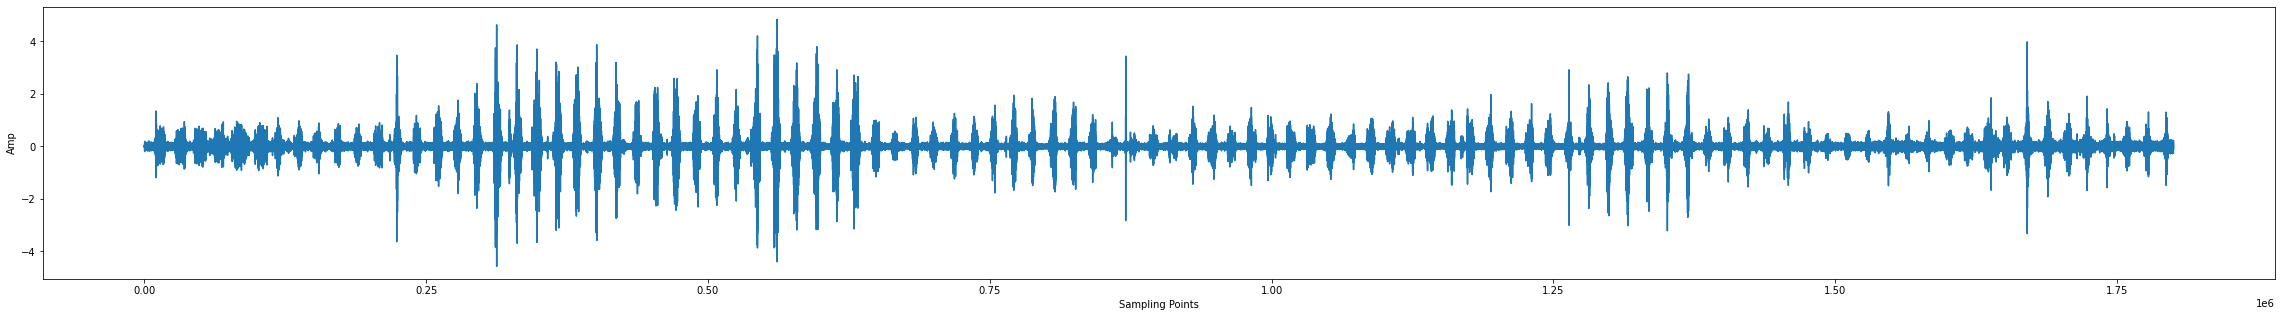

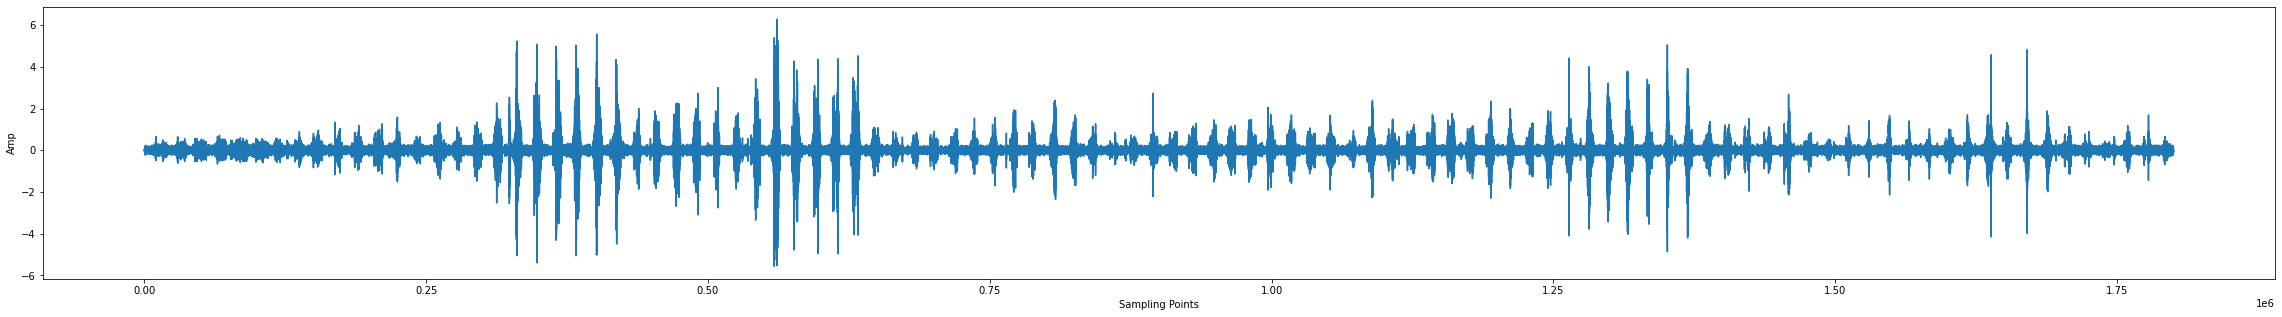

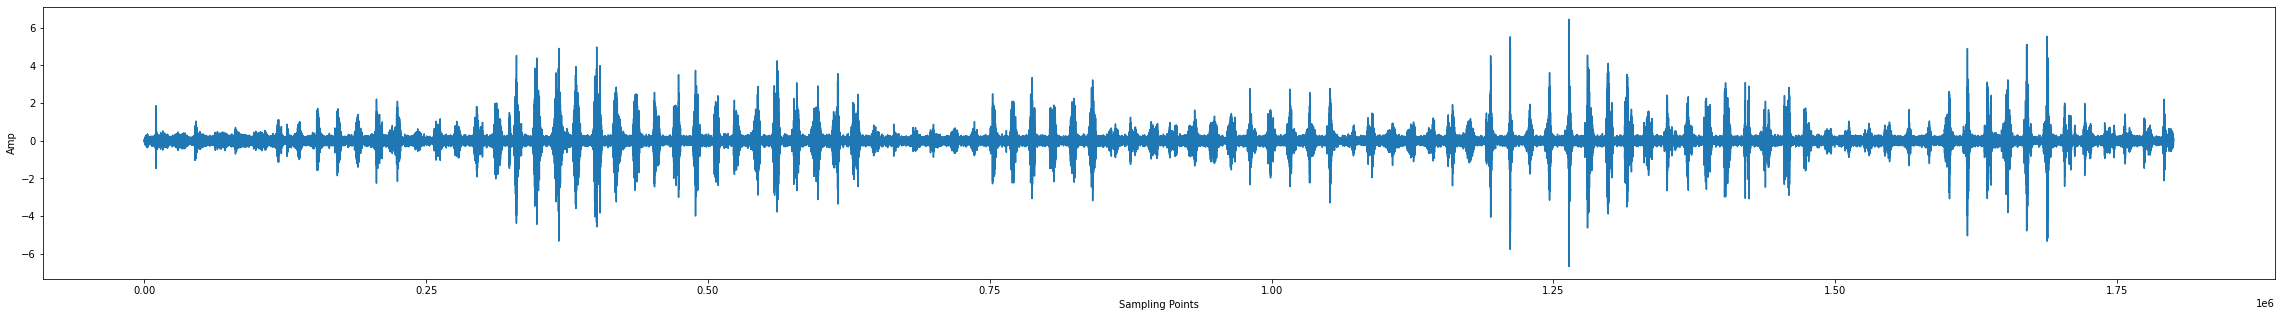

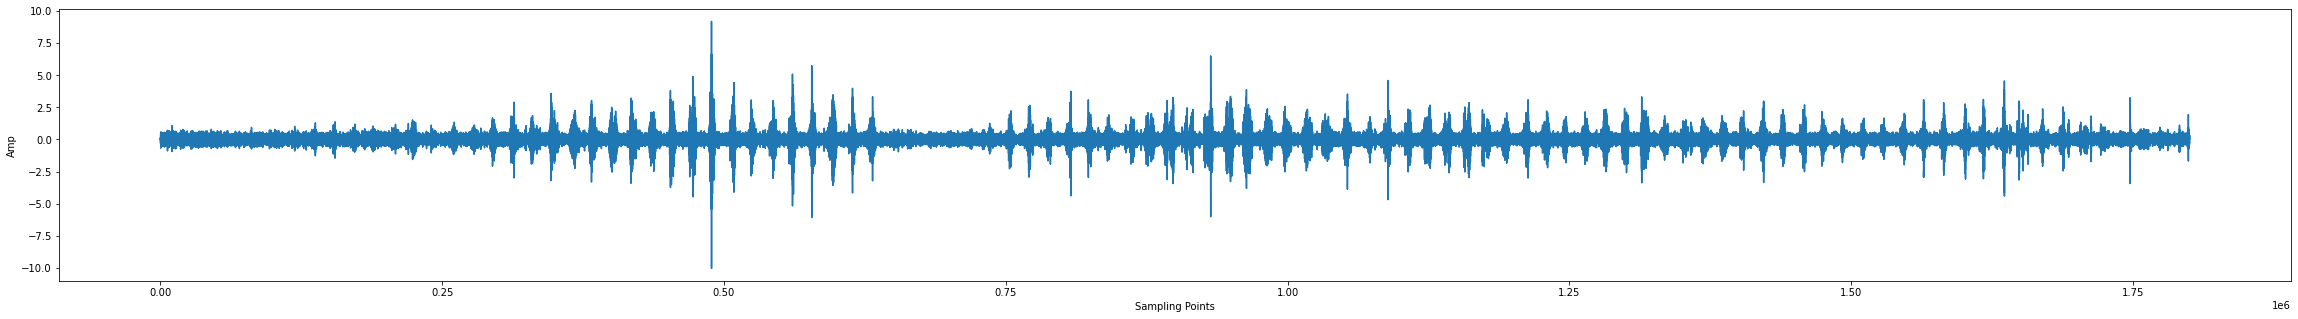

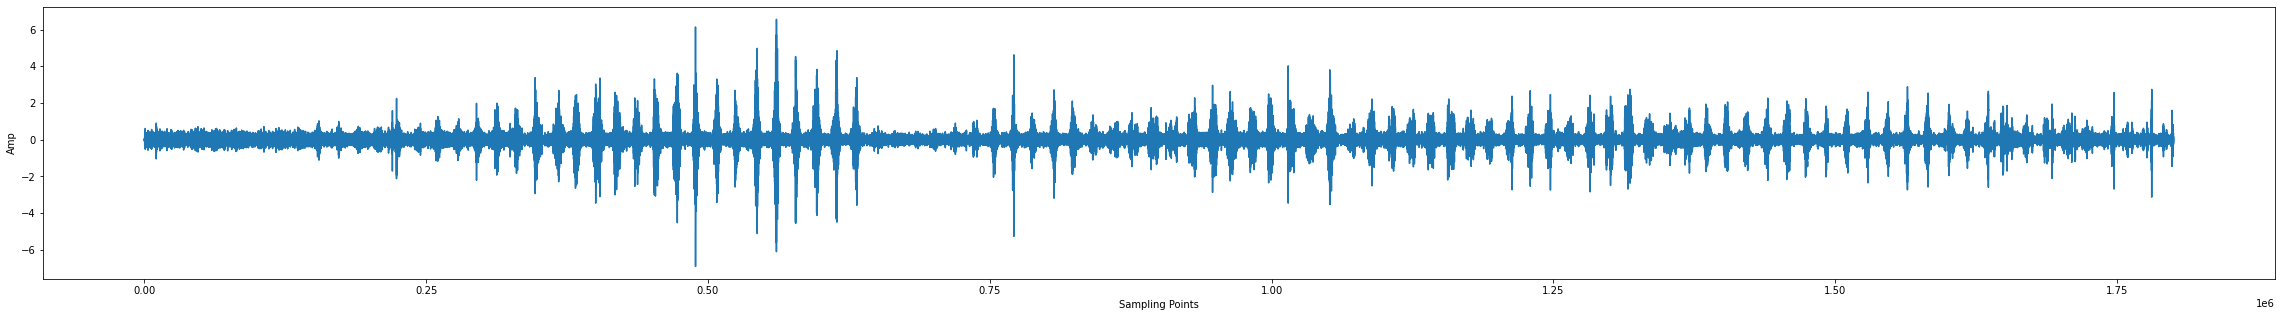

In [237]:
figure(figsize=(40, 5))

plt.plot(emg_band[0])

plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()
figure(figsize=(40, 5))

plt.plot(emg_band[1])

plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()
figure(figsize=(40, 5))

plt.plot(emg_band[2])

plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()
figure(figsize=(40, 5))

plt.plot(emg_band[3])

plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()
figure(figsize=(40, 5))

plt.plot(emg_band[4])

plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()
figure(figsize=(40, 5))

plt.plot(emg_band[5])

plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()
figure(figsize=(40, 5))

plt.plot(emg_band[6])

plt.xlabel('Sampling Points')
plt.ylabel('Amp')
plt.show()

Check if the stimulus (gesture) information is still correct.

In [238]:
np.unique(emg_band.stimulus)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int8)

Feature extraction for the moving windows, moving windows are set as 200ms with 50% overlap.

In [239]:
def windowing(data, reps, gestures, win_len, win_stride):
    if reps:
        x = [np.where(data.values[:, 13] == rep) for rep in reps]
        indices = np.squeeze(np.concatenate(x, axis=-1))
        data = data.iloc[indices, :]
        data = data.reset_index(drop=True)

    if gestures:
        x = [np.where(data.values[:, 12] == move) for move in gestures]
        indices = np.squeeze(np.concatenate(x, axis=-1))
        data = data.iloc[indices, :]
        data = data.reset_index(drop=True)

    idx = [i for i in range(win_len, len(data), win_stride)]

    X = np.zeros([len(idx), win_len, len(data.columns) - 2])
    y = np.zeros([len(idx), ])
    reps = np.zeros([len(idx), ])

    for i, end in enumerate(idx):
        start = end - win_len
        X[i] = data.iloc[start:end, 0:12].values
        y[i] = data.iloc[end, 12]
        reps[i] = data.iloc[end, 13]

    return X, y, reps

In [240]:
X, y, r = windowing(emg_band, [1,2,3,4,5,6], [1,2,3,4,5,6], 200, 100)

X are the iput variables, while y is the target. The X are the raw window information, rms and zero_cross will be extracted as features for further classification.

In [241]:
def rms(data):
    return np.sqrt(np.mean(data ** 2))

def zero_cross(data):
    return len(np.where(np.diff(np.sign(data)))[0]) / len(data)

def feature_extractor(features, shape, data):
    l = pd.DataFrame()
    for i, function in enumerate(tqdm(features)):
        feature = []
        print("Extracting feature....{}".format(str(function)))
        for i in range(data.shape[0]):
            for j in range(data.shape[2]):
                feature.append(function(data[i][:, j]))
        feature = np.reshape(feature, shape)
        l = pd.concat([l, pd.DataFrame(feature)], axis=1)
        print("Done extracting feature....{}".format(str(function)))
        print()
    return l

In [242]:
feature_matrix = feature_extractor([rms,zero_cross],(X.shape[0],-1),X)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Extracting feature....<function rms at 0x00000150C59C8DC0>


 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  2.80it/s]

Done extracting feature....<function rms at 0x00000150C59C8DC0>

Extracting feature....<function zero_cross at 0x00000150C59C8EE0>


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.24it/s]

Done extracting feature....<function zero_cross at 0x00000150C59C8EE0>



Check the feature matrix have the correct shape.

In [243]:
feature_matrix

,0,1,2,3,4,5,6,7,8,9,...,2,3,4,5,6,7,8,9,10,11
0,0.048553,0.047166,0.067204,0.077938,0.073620,0.308927,0.046320,0.054930,0.055678,0.074597,...,0.040,0.030,0.035,0.025,0.035,0.035,0.035,0.025,0.030,0.040
1,0.050182,0.054828,0.069483,0.099965,0.036400,0.292527,0.050666,0.054628,0.039714,0.058786,...,0.035,0.030,0.040,0.035,0.035,0.030,0.035,0.025,0.030,0.035
2,0.065216,0.039008,0.060326,0.085033,0.054260,0.177084,0.059159,0.053117,0.034507,0.072646,...,0.030,0.030,0.035,0.030,0.030,0.035,0.030,0.025,0.025,0.025
3,0.070059,0.042102,0.044390,0.099415,0.105644,0.214052,0.113516,0.053397,0.034337,0.096424,...,0.040,0.025,0.030,0.020,0.035,0.040,0.040,0.020,0.025,0.030
4,0.053847,0.045310,0.043103,0.109356,0.101158,0.224220,0.141910,0.055100,0.023680,0.115405,...,0.035,0.035,0.035,0.030,0.030,0.030,0.035,0.025,0.025,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3326,0.292234,0.518257,0.721490,1.012447,0.991981,0.605042,0.448129,0.340674,1.164744,0.865617,...,0.035,0.035,0.035,0.035,0.030,0.030,0.030,0.035,0.020,0.030
3327,0.407323,0.248661,0.506441,0.792029,0.636985,0.627351,0.427300,0.494206,0.941023,0.529948,...,0.035,0.035,0.030,0.040,0.035,0.035,0.030,0.040,0.020,0.035
3328,0.431232,0.201107,0.399069,0.487754,0.333928,0.609492,0.457798,0.486824,0.780485,0.391338,...,0.030,0.030,0.030,0.040,0.040,0.040,0.030,0.030,0.030,0.040
3329,0.285051,0.185429,0.401481,0.433721,0.274150,0.437232,0.437932,0.322032,0.556653,0.460068,...,0.035,0.025,0.040,0.030,0.040,0.040,0.035,0.020,0.035,0.040


Split the data into training and testing set. testing set size is 30%.

In [244]:
x_train, x_test, y_train, y_test = train_test_split(feature_matrix, y, test_size=0.3)

Apply logistic regression as the tool for modeling. Get the score for testing set accuracy.

In [245]:
clf = LogisticRegression(multi_class='ovr', solver='liblinear').fit(x_train, y_train)
clf.score(x_train, y_train)

0.646932646932647

There are totally 24 weights for the input variables.For the 6 classes, the weights are calculated as below.

In [246]:
weights = pd.DataFrame(clf.coef_)

In [247]:
weights

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,-0.327984,2.725751,4.528564,-2.829677,-2.667811,-2.910467,-4.213645,3.456837,-1.402996,-4.633770,...,0.170995,0.255279,-0.084120,-0.050222,-0.082892,0.172206,0.064009,0.116948,0.081313,-0.252674
1,-5.356202,-4.059581,-3.900201,-0.784648,1.793773,-0.540058,-4.119854,1.828956,1.136691,2.561391,...,0.177746,0.143972,0.337858,0.079327,-0.052607,-0.127039,0.206471,-0.029391,-0.000771,-0.186221
2,6.344584,-4.705214,2.054316,-2.975076,-1.765371,-1.103856,-0.910677,-2.214960,1.487515,1.387900,...,-0.103704,-0.267381,0.021596,0.188405,0.022369,-0.099189,0.063617,-0.084695,-0.218083,0.410703
3,-1.040176,-5.084252,-0.366908,2.857247,3.578045,-3.031599,2.270141,1.234266,-1.790097,-1.179262,...,-0.014205,-0.020278,0.117114,-0.133181,0.124201,0.175049,0.141158,0.011974,-0.207521,0.011855
4,1.311315,-3.500792,-0.077090,0.880789,-1.021580,3.263321,0.184880,0.002385,-2.343312,0.358404,...,-0.124977,-0.099225,-0.264053,-0.152129,-0.030516,0.081369,-0.400552,-0.189852,0.240442,-0.077677
5,-1.683735,6.962447,-2.285564,1.409594,-1.813678,0.946173,0.047145,-0.731614,2.519717,1.367435,...,-0.076605,-0.028205,-0.068626,0.013822,-0.062923,-0.171562,-0.062199,-0.087066,-0.231997,-0.070759
